## Сравниваем написанную модель ResNet и предобученную для определения цвета машины из датасета, взятого по адресу https://deepvisualmarketing.github.io/.

In [33]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import copy
from torchvision import transforms, models

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [35]:
print(torch.version.cuda)

11.8


In [36]:
data_dir = "confirmed_fronts"
data = []

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith((".jpg")): 
            parts = file.split("$$")
            if len(parts) >= 4:  
                brand = parts[0]
                model = parts[1]
                year = parts[2]
                color = parts[3]  
                
                image_path = os.path.join(root, file)

                if (color != "Unlisted"):
                    data.append((image_path, brand, model, year, color))


df = pd.DataFrame(data, columns=["image_path", "brand", "model", "year", "color"])
top_colors = df['color'].value_counts().nlargest(10).index
df = df[df['color'].isin(top_colors)].copy()

max_count = int(df['color'].value_counts().mean())
df = df.groupby('color').apply(lambda x: x.sample(min(len(x), max_count), random_state=42)).reset_index(drop=True)
df.to_csv("dataset.csv", index=False)  

C:\Users\kapgo\AppData\Local\Temp\ipykernel_3376\2829426709.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('color').apply(lambda x: x.sample(min(len(x), max_count), random_state=42)).reset_index(drop=True)


In [37]:
transform = transforms.Compose([
    transforms.Resize((128,128)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

all_colors = df['color'].unique()
label_encoder = LabelEncoder()
label_encoder.fit(all_colors) 

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df["color"] = label_encoder.transform(train_df["color"])
test_df["color"] = label_encoder.transform(test_df["color"])


In [38]:
class CarColorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row["color"], dtype=torch.long)
        return img, label

train_dataset = CarColorDataset(train_df, transform)
test_dataset = CarColorDataset(test_df, transform)

# Классификатор

In [39]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.res_block1 = self._make_residual_block(64, 128, downsample=True)
        self.res_block2 = self._make_residual_block(128, 128)
        self.res_block3 = self._make_residual_block(128, 256, downsample=True)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  
        
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.color_attention = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        attention = self.color_attention(x)
        x = x * attention
        
        x = self.adaptive_pool(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

    def _make_residual_block(self, in_channels, out_channels, downsample=False):
        shortcut = nn.Sequential()
        stride = 1
        
        if downsample:
            stride = 2
            shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        elif in_channels != out_channels:
            shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )

        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        return ResidualBlock(block, shortcut)

class ResidualBlock(nn.Module):
    def __init__(self, block, shortcut):
        super().__init__()
        self.block = block
        self.shortcut = shortcut

    def forward(self, x):
        return F.relu(self.block(x) + self.shortcut(x))


In [40]:
def plot_confusion_matrix(y_true, y_pred, classes, epoch):
    y_true = label_encoder.inverse_transform(y_true)
    y_pred = label_encoder.inverse_transform(y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    
    # Строим тепловую карту
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Обучение модели

In [41]:
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001, batch_size=32):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

    train_losses = []
    test_losses = []
    f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_train_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_losses.append(running_test_loss / len(test_loader))
        f1 = f1_score(all_labels, all_preds, average='macro')
        f1_scores.append(f1)

        plot_confusion_matrix(all_labels, all_preds, classes=label_encoder.classes_, epoch=epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_losses[-1]:.4f}, F1 Score: {f1:.4f}")

    return train_losses, test_losses, f1_scores


# Подбор гиперпараметров


Обучение с lr=0.0001, batch_size=128, epochs=12


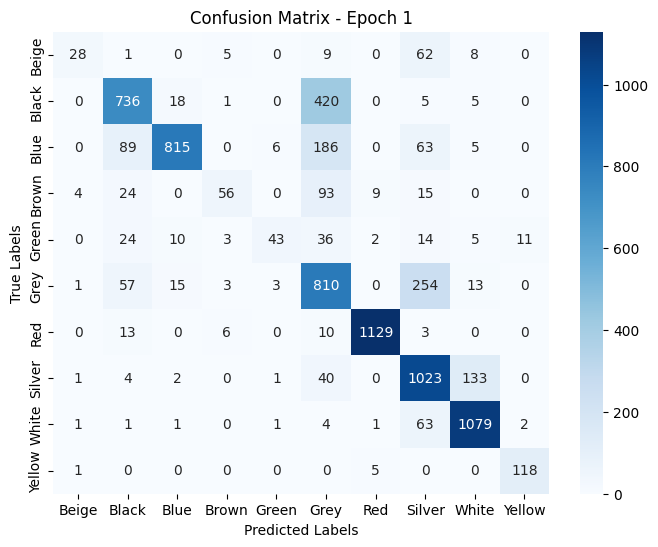

Epoch [1/12], Train Loss: 0.8446, Train Accuracy: 70.94%, Test Loss: 0.6500, F1 Score: 0.6849


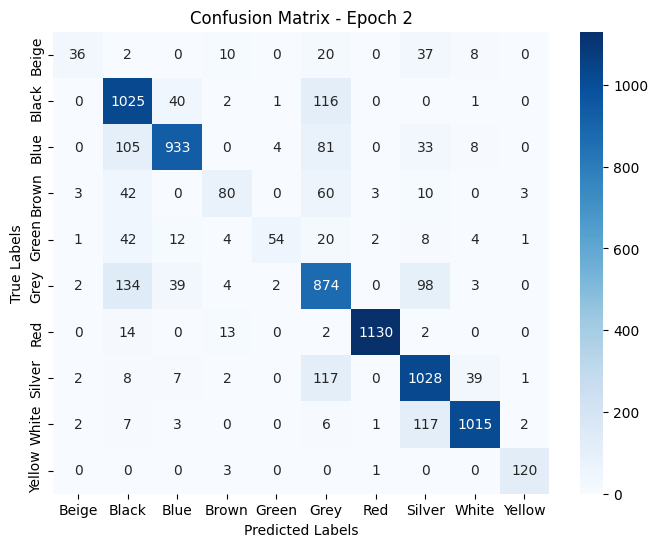

Epoch [2/12], Train Loss: 0.5804, Train Accuracy: 80.80%, Test Loss: 0.5216, F1 Score: 0.7492


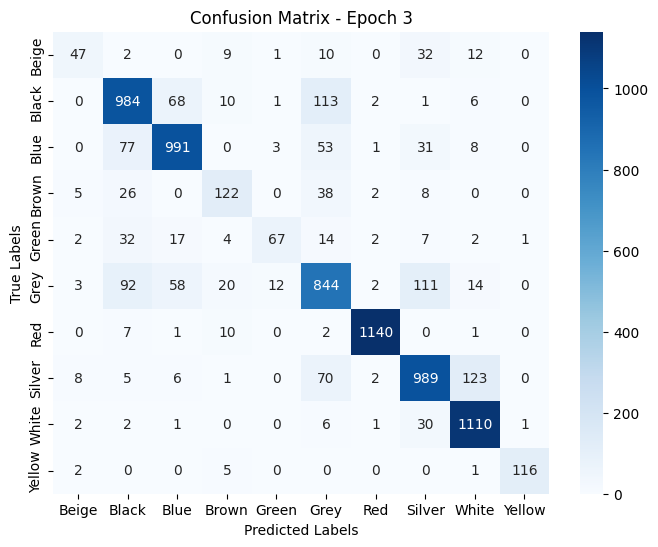

Epoch [3/12], Train Loss: 0.4961, Train Accuracy: 83.58%, Test Loss: 0.4672, F1 Score: 0.7818


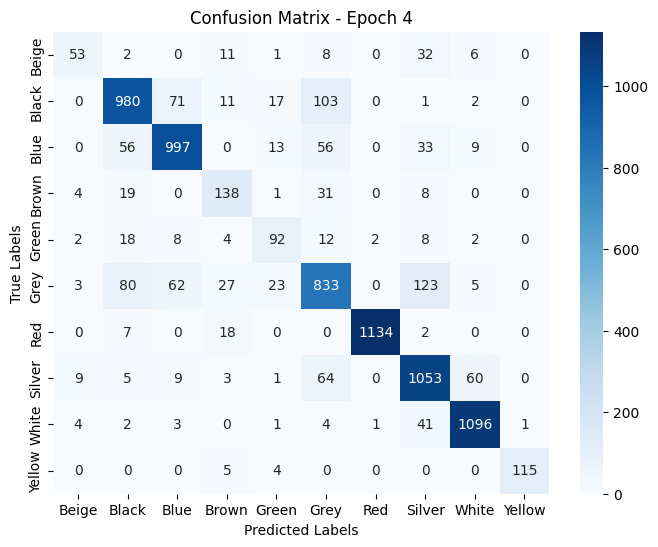

Epoch [4/12], Train Loss: 0.4423, Train Accuracy: 85.56%, Test Loss: 0.4417, F1 Score: 0.7990


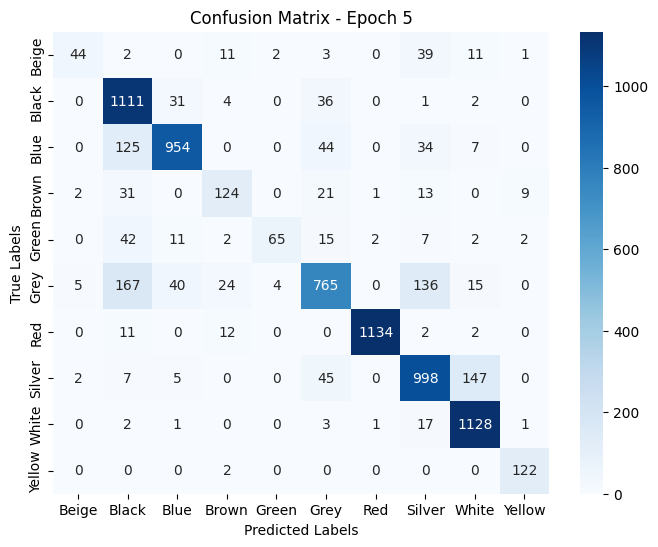

Epoch [5/12], Train Loss: 0.4004, Train Accuracy: 87.02%, Test Loss: 0.4641, F1 Score: 0.7860


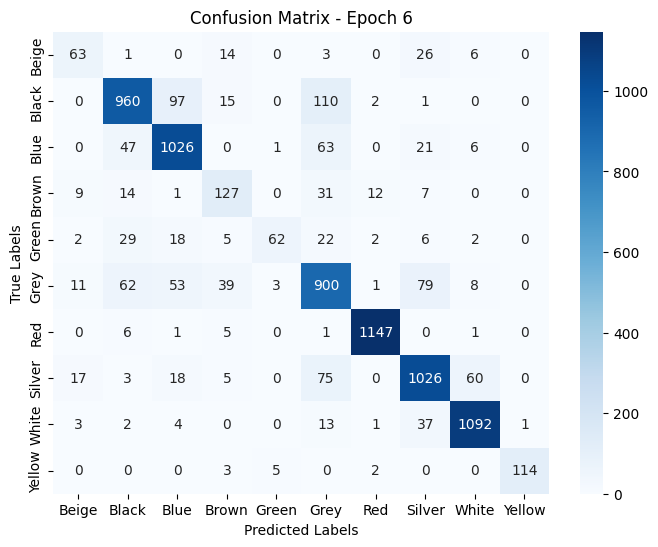

Epoch [6/12], Train Loss: 0.3647, Train Accuracy: 88.12%, Test Loss: 0.4445, F1 Score: 0.7939


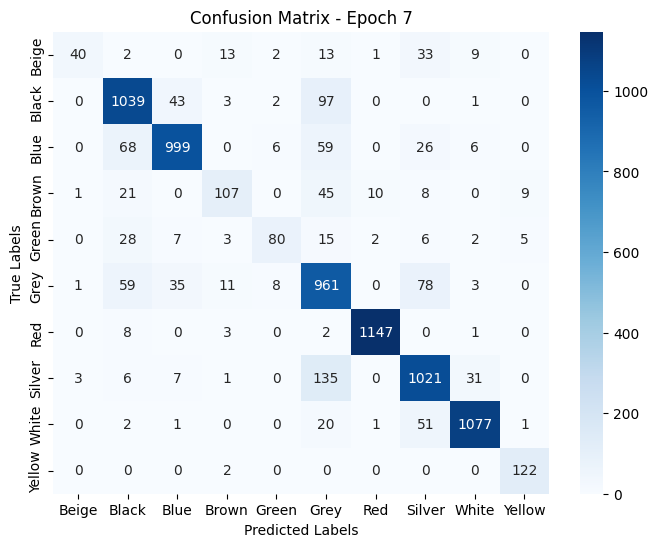

Epoch [7/12], Train Loss: 0.3248, Train Accuracy: 89.49%, Test Loss: 0.4102, F1 Score: 0.7999


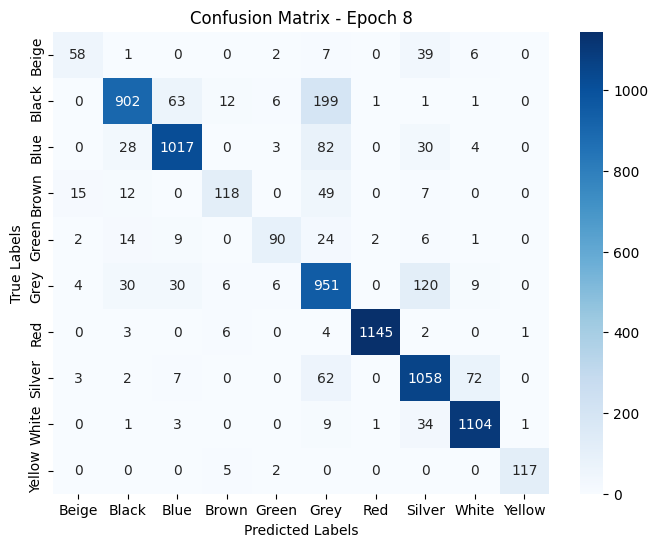

Epoch [8/12], Train Loss: 0.2873, Train Accuracy: 90.63%, Test Loss: 0.4253, F1 Score: 0.8177


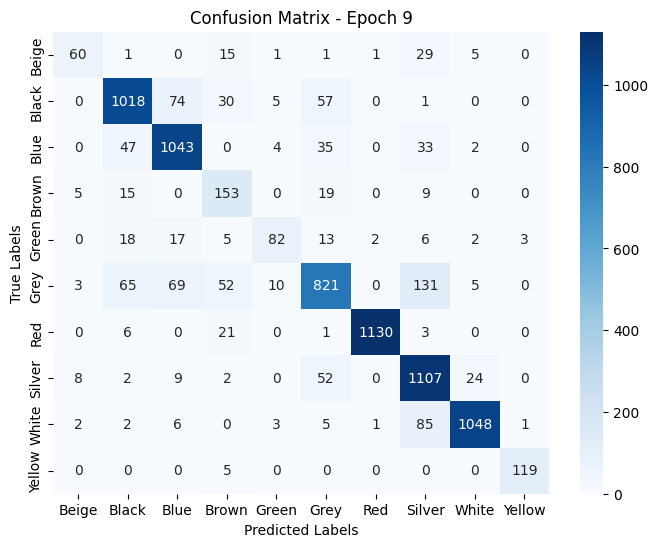

Epoch [9/12], Train Loss: 0.2560, Train Accuracy: 91.63%, Test Loss: 0.4065, F1 Score: 0.8141


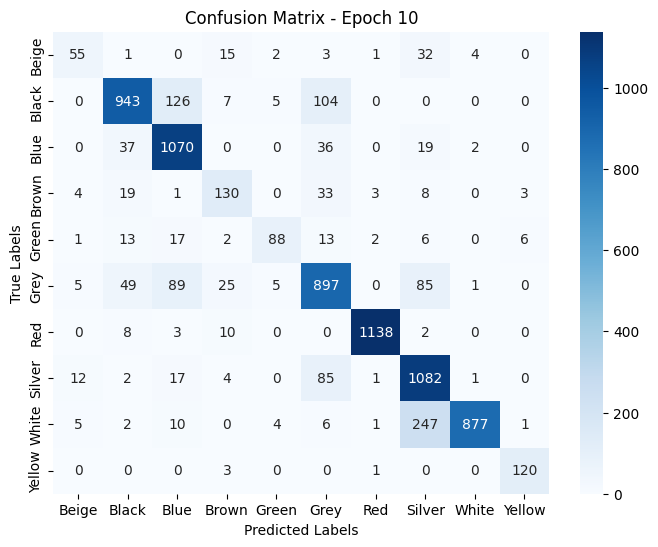

Epoch [10/12], Train Loss: 0.2172, Train Accuracy: 92.96%, Test Loss: 0.4767, F1 Score: 0.7976


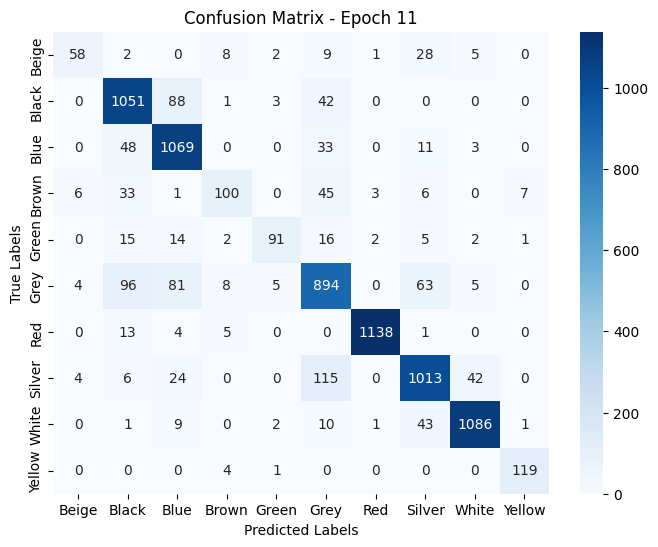

Epoch [11/12], Train Loss: 0.1813, Train Accuracy: 94.16%, Test Loss: 0.4277, F1 Score: 0.8188


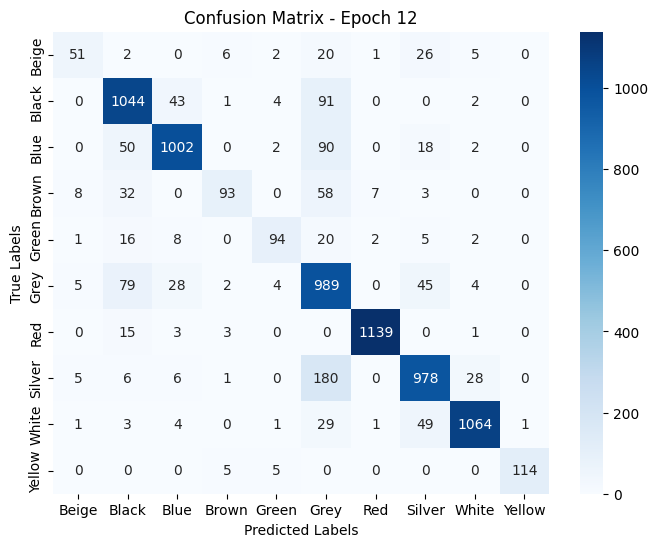

Epoch [12/12], Train Loss: 0.1527, Train Accuracy: 95.02%, Test Loss: 0.4702, F1 Score: 0.8092

Обучение с lr=0.0001, batch_size=64, epochs=12


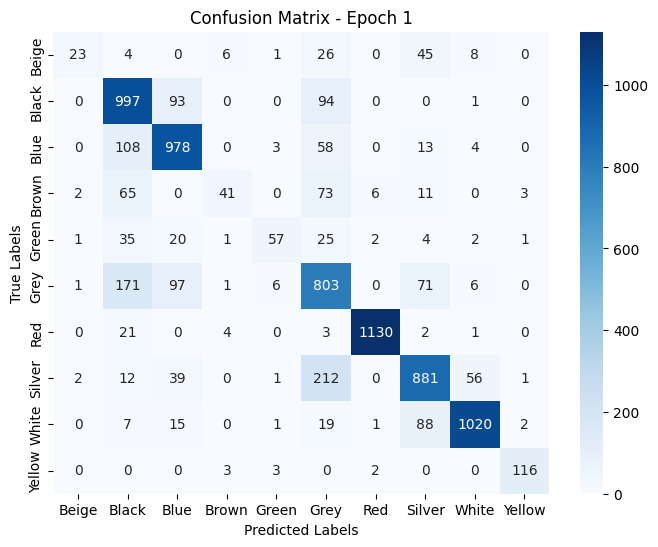

Epoch [1/12], Train Loss: 0.7998, Train Accuracy: 72.49%, Test Loss: 0.6122, F1 Score: 0.6977


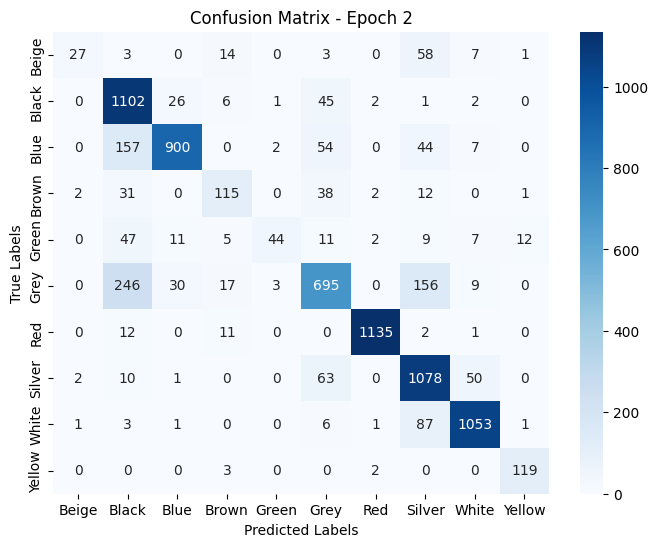

Epoch [2/12], Train Loss: 0.5707, Train Accuracy: 80.96%, Test Loss: 0.5293, F1 Score: 0.7379


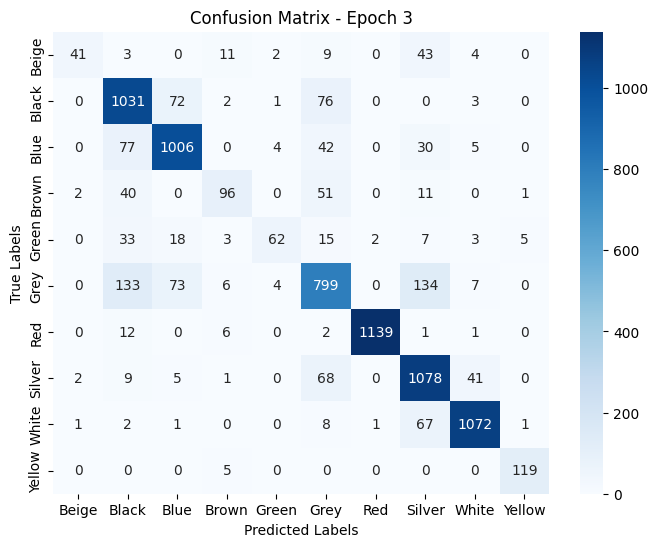

Epoch [3/12], Train Loss: 0.4913, Train Accuracy: 83.76%, Test Loss: 0.4713, F1 Score: 0.7767


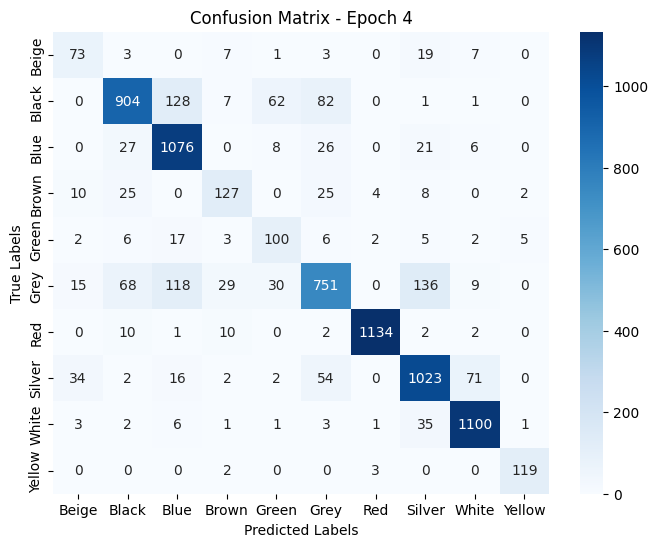

Epoch [4/12], Train Loss: 0.4342, Train Accuracy: 85.73%, Test Loss: 0.4874, F1 Score: 0.7881


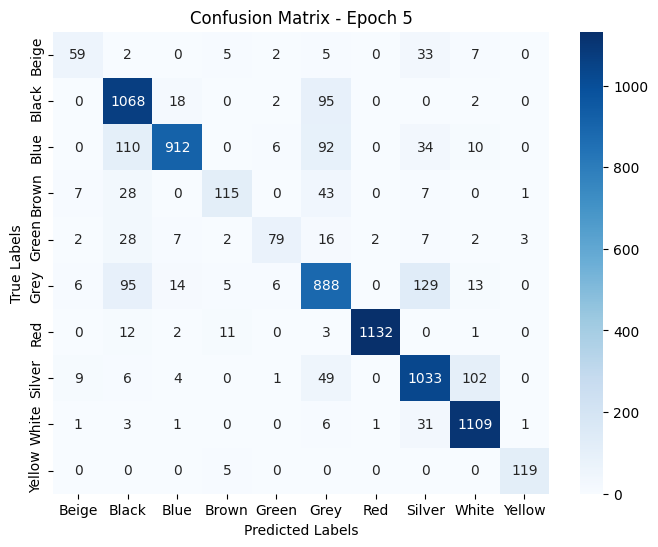

Epoch [5/12], Train Loss: 0.3946, Train Accuracy: 87.04%, Test Loss: 0.4438, F1 Score: 0.8075


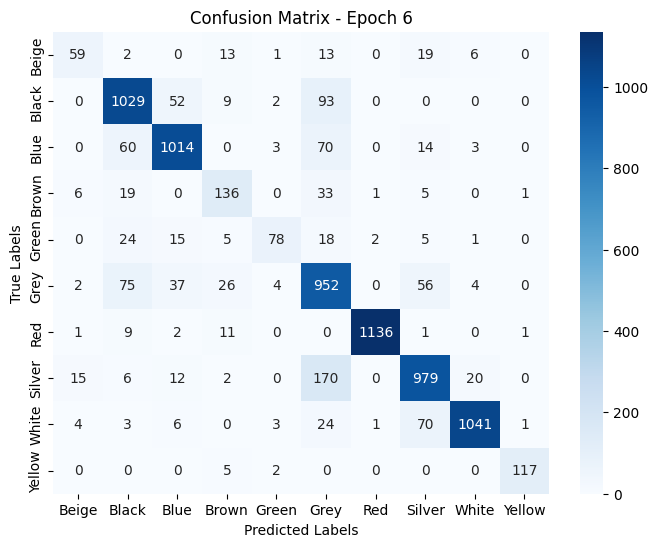

Epoch [6/12], Train Loss: 0.3529, Train Accuracy: 88.54%, Test Loss: 0.4350, F1 Score: 0.8104


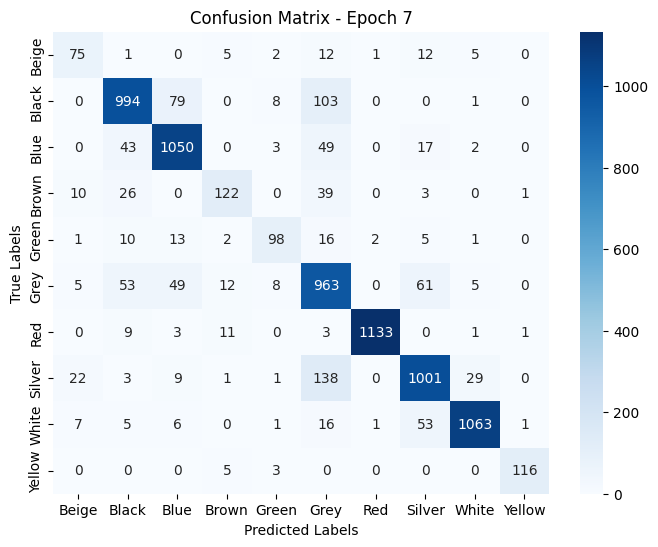

Epoch [7/12], Train Loss: 0.3208, Train Accuracy: 89.49%, Test Loss: 0.4063, F1 Score: 0.8286


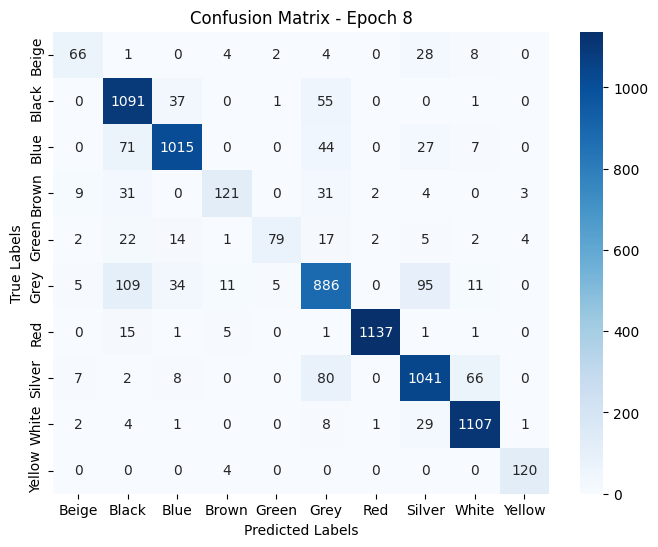

Epoch [8/12], Train Loss: 0.2841, Train Accuracy: 90.53%, Test Loss: 0.3915, F1 Score: 0.8283


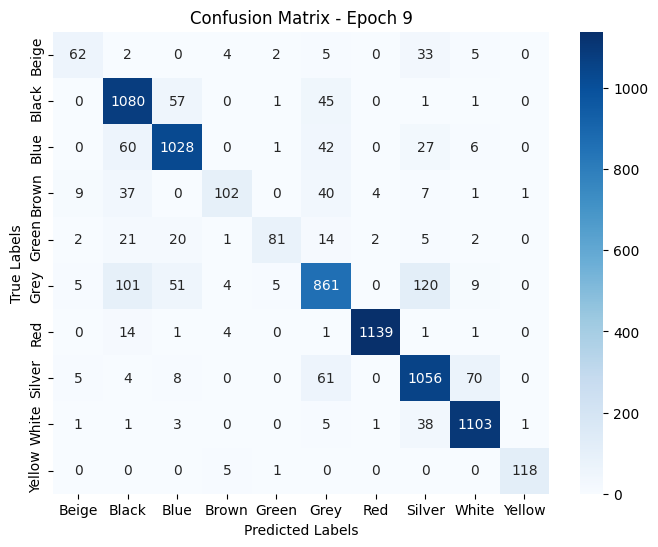

Epoch [9/12], Train Loss: 0.2471, Train Accuracy: 91.92%, Test Loss: 0.4052, F1 Score: 0.8199


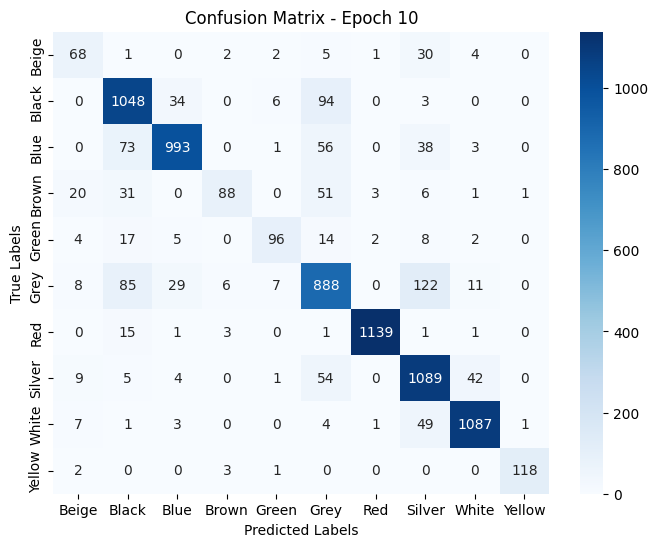

Epoch [10/12], Train Loss: 0.2163, Train Accuracy: 92.75%, Test Loss: 0.4205, F1 Score: 0.8160


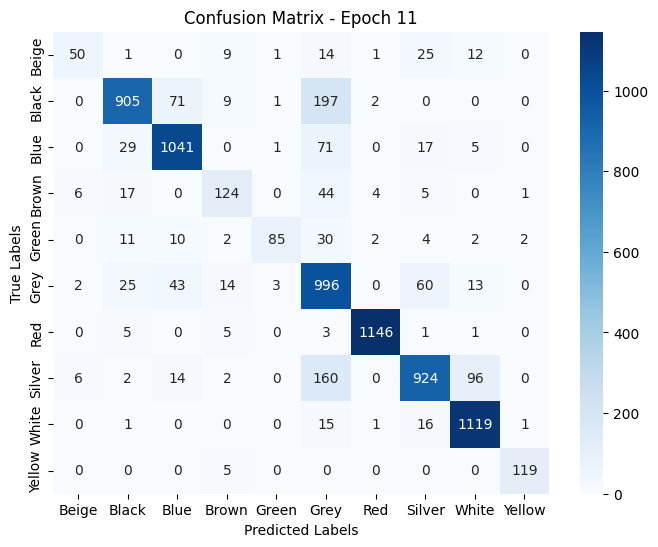

Epoch [11/12], Train Loss: 0.1814, Train Accuracy: 94.15%, Test Loss: 0.4592, F1 Score: 0.8109


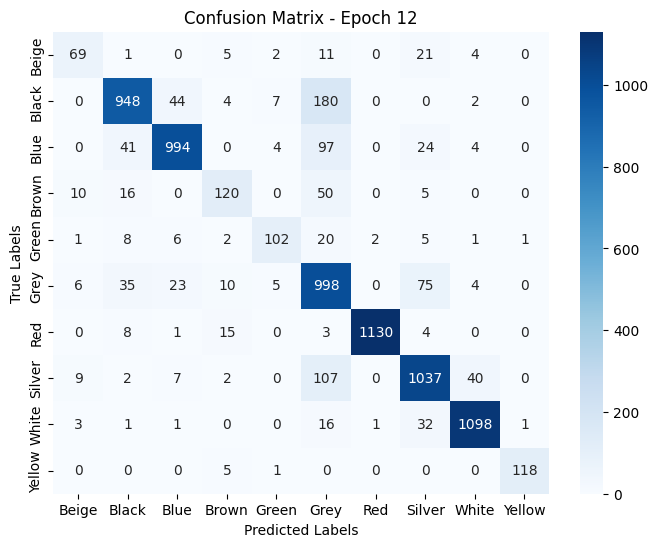

Epoch [12/12], Train Loss: 0.1545, Train Accuracy: 94.94%, Test Loss: 0.4625, F1 Score: 0.8327

Обучение с lr=0.001, batch_size=128, epochs=12


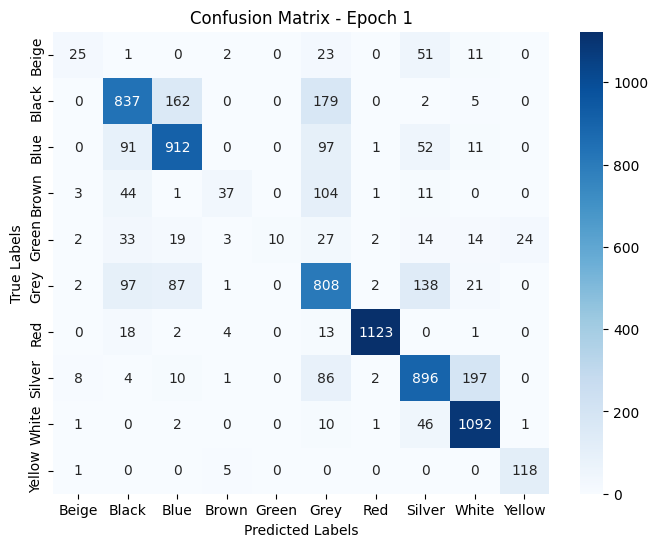

Epoch [1/12], Train Loss: 0.9384, Train Accuracy: 68.03%, Test Loss: 0.6909, F1 Score: 0.6362


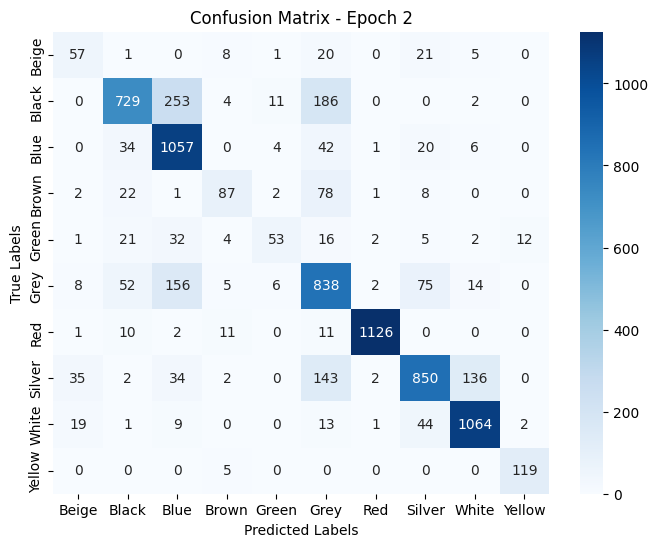

Epoch [2/12], Train Loss: 0.6421, Train Accuracy: 78.76%, Test Loss: 0.6132, F1 Score: 0.7209


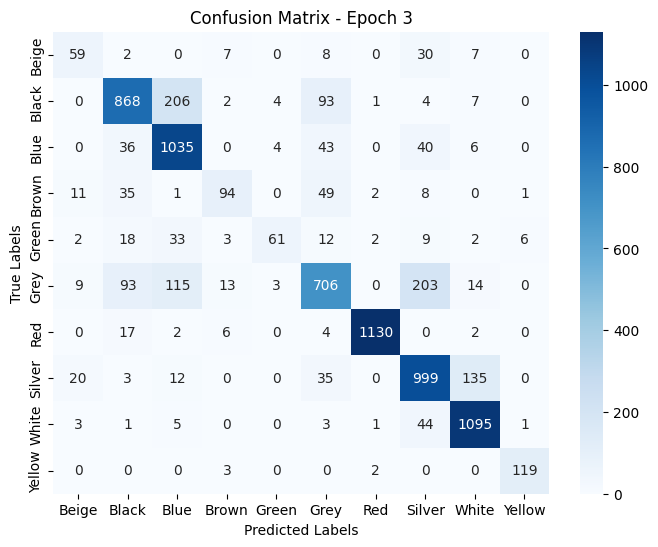

Epoch [3/12], Train Loss: 0.5442, Train Accuracy: 81.89%, Test Loss: 0.5489, F1 Score: 0.7535


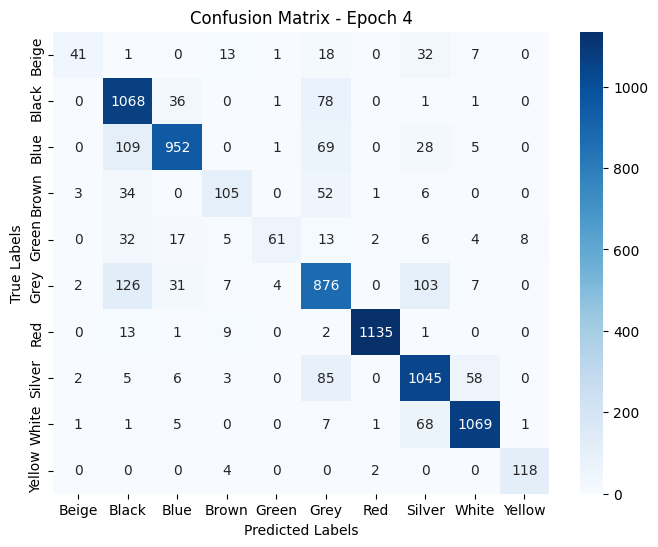

Epoch [4/12], Train Loss: 0.4826, Train Accuracy: 84.06%, Test Loss: 0.4480, F1 Score: 0.7803


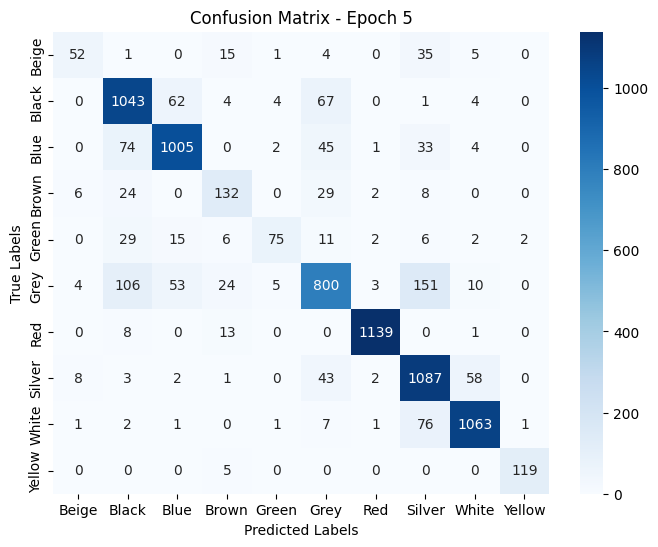

Epoch [5/12], Train Loss: 0.4291, Train Accuracy: 85.83%, Test Loss: 0.4374, F1 Score: 0.8029


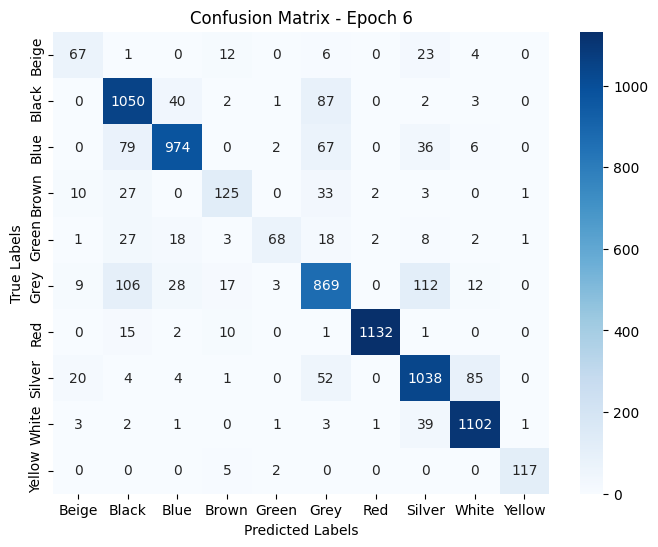

Epoch [6/12], Train Loss: 0.3922, Train Accuracy: 87.07%, Test Loss: 0.4284, F1 Score: 0.8060


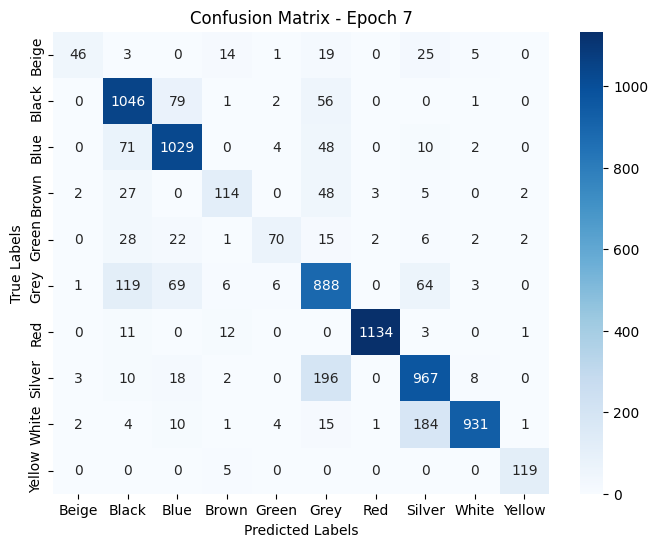

Epoch [7/12], Train Loss: 0.3478, Train Accuracy: 88.40%, Test Loss: 0.5096, F1 Score: 0.7819


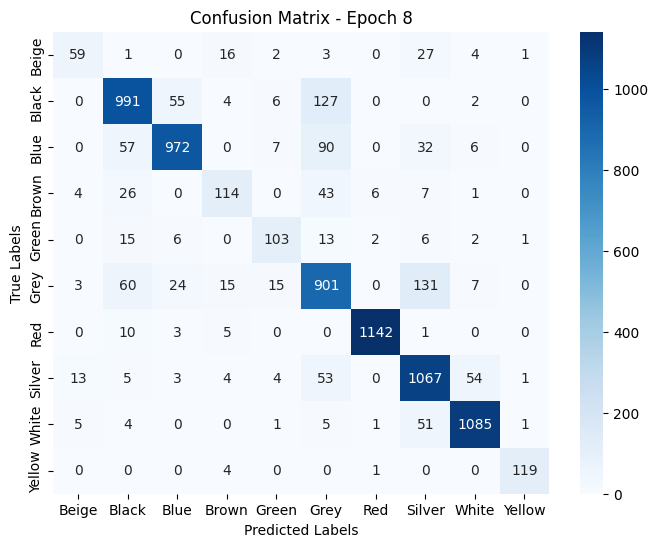

Epoch [8/12], Train Loss: 0.3104, Train Accuracy: 89.65%, Test Loss: 0.4328, F1 Score: 0.8150


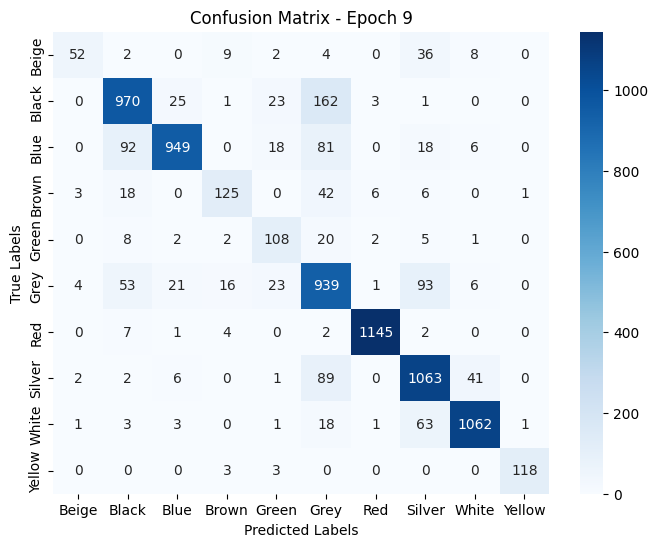

Epoch [9/12], Train Loss: 0.2754, Train Accuracy: 90.75%, Test Loss: 0.4319, F1 Score: 0.8139


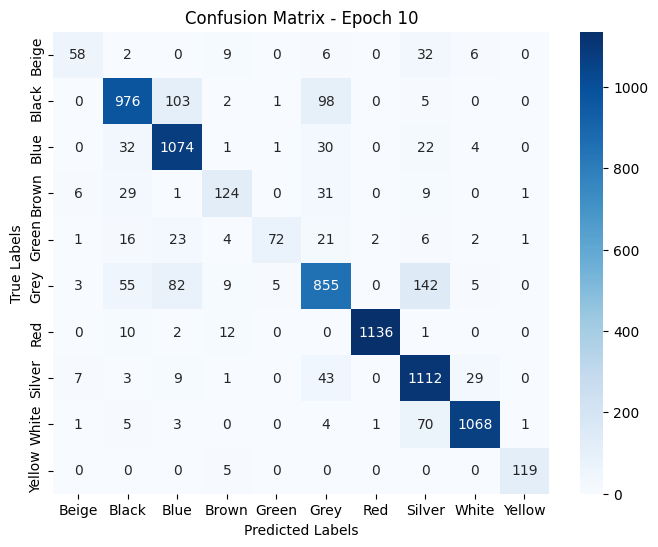

Epoch [10/12], Train Loss: 0.2366, Train Accuracy: 91.97%, Test Loss: 0.4329, F1 Score: 0.8153


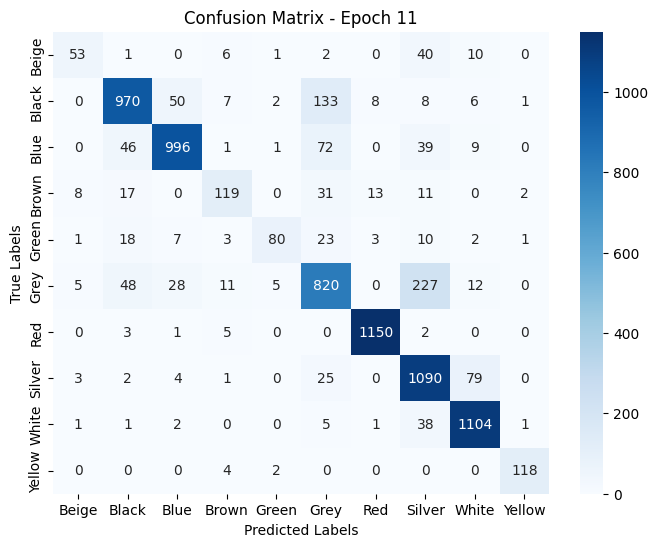

Epoch [11/12], Train Loss: 0.2014, Train Accuracy: 93.16%, Test Loss: 0.4976, F1 Score: 0.8052


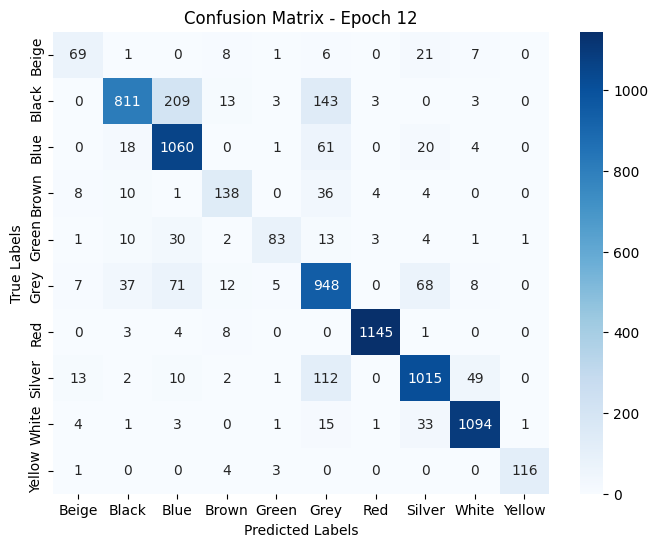

Epoch [12/12], Train Loss: 0.1649, Train Accuracy: 94.20%, Test Loss: 0.5048, F1 Score: 0.8145

Обучение с lr=0.001, batch_size=64, epochs=12


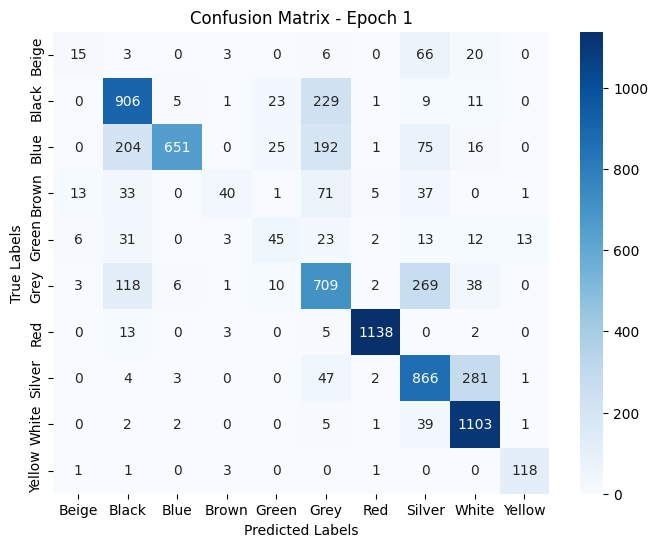

Epoch [1/12], Train Loss: 0.8941, Train Accuracy: 69.15%, Test Loss: 0.7658, F1 Score: 0.6293


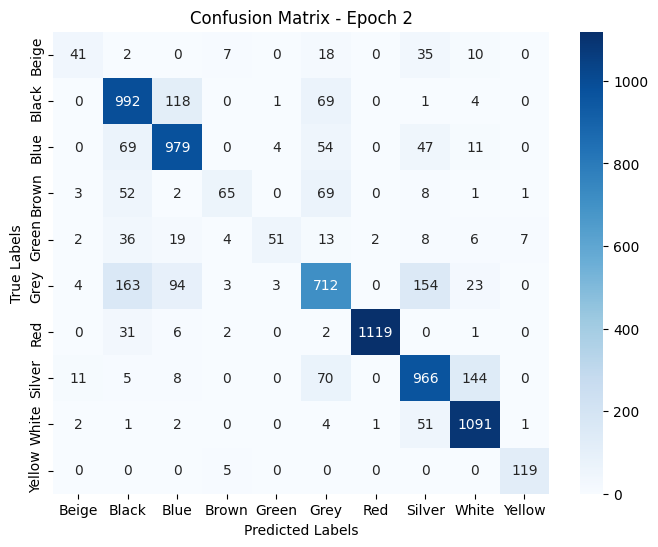

Epoch [2/12], Train Loss: 0.6237, Train Accuracy: 79.03%, Test Loss: 0.6048, F1 Score: 0.7268


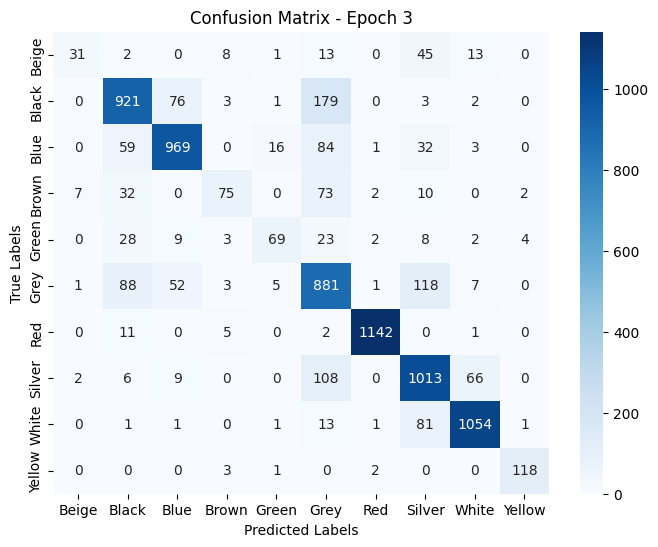

Epoch [3/12], Train Loss: 0.5346, Train Accuracy: 82.26%, Test Loss: 0.5292, F1 Score: 0.7464


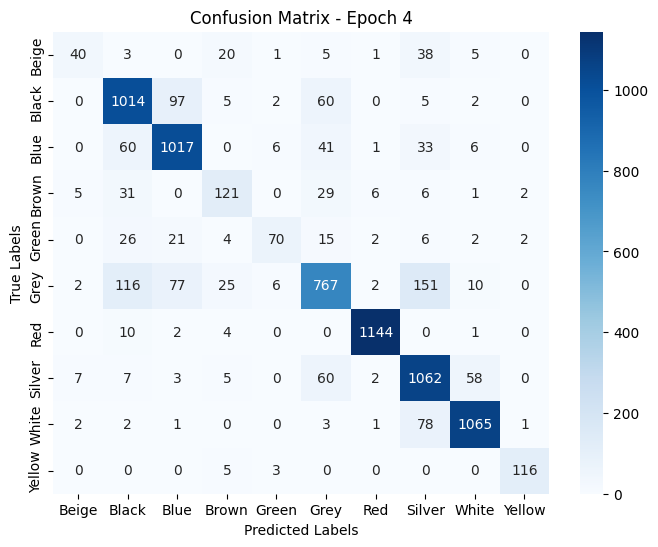

Epoch [4/12], Train Loss: 0.4726, Train Accuracy: 84.39%, Test Loss: 0.4725, F1 Score: 0.7766


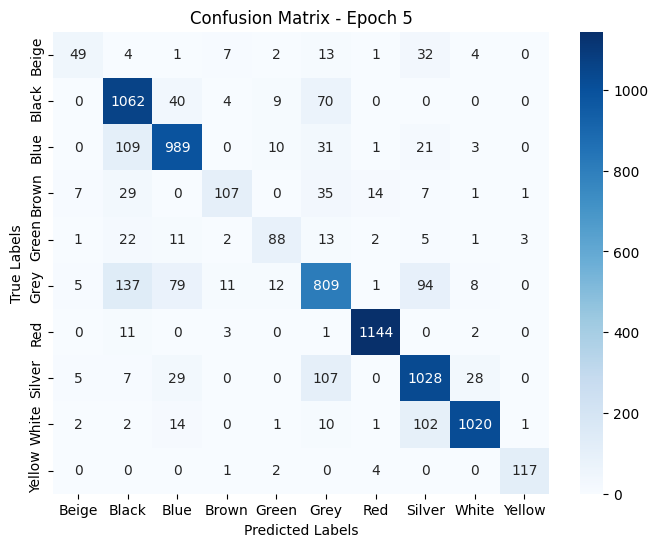

Epoch [5/12], Train Loss: 0.4273, Train Accuracy: 85.75%, Test Loss: 0.4652, F1 Score: 0.7898


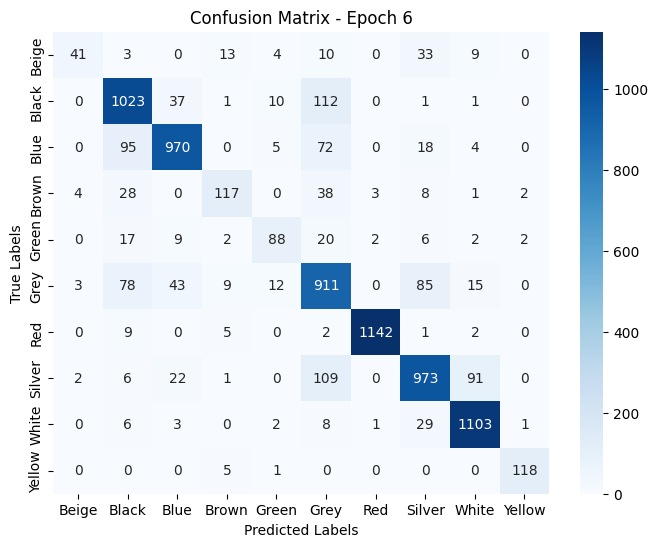

Epoch [6/12], Train Loss: 0.3872, Train Accuracy: 87.32%, Test Loss: 0.4429, F1 Score: 0.7958


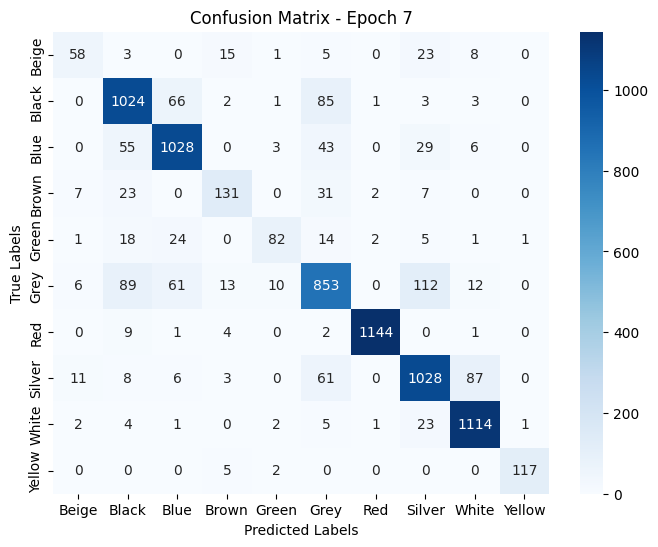

Epoch [7/12], Train Loss: 0.3424, Train Accuracy: 88.52%, Test Loss: 0.4142, F1 Score: 0.8155


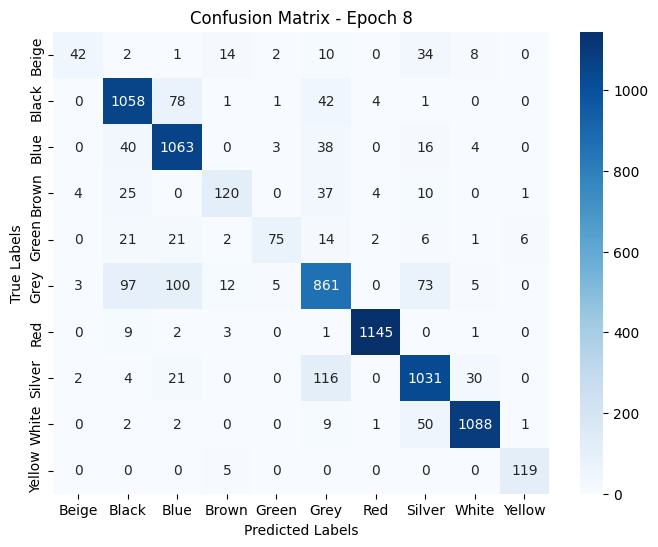

Epoch [8/12], Train Loss: 0.3010, Train Accuracy: 89.75%, Test Loss: 0.4504, F1 Score: 0.8048


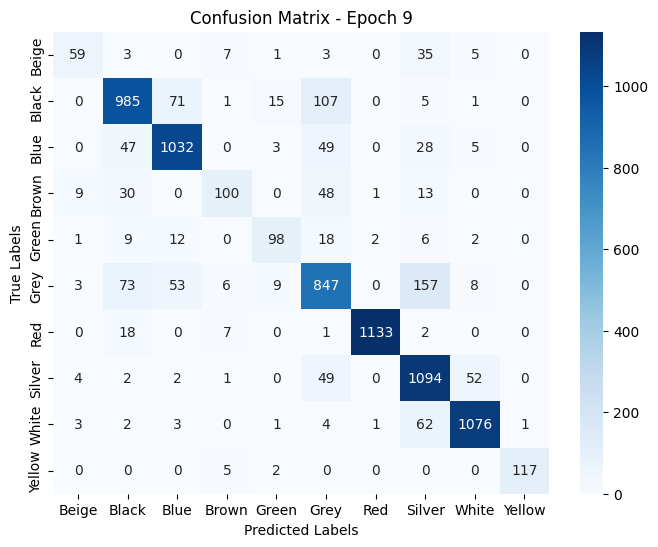

Epoch [9/12], Train Loss: 0.2644, Train Accuracy: 90.95%, Test Loss: 0.4636, F1 Score: 0.8122


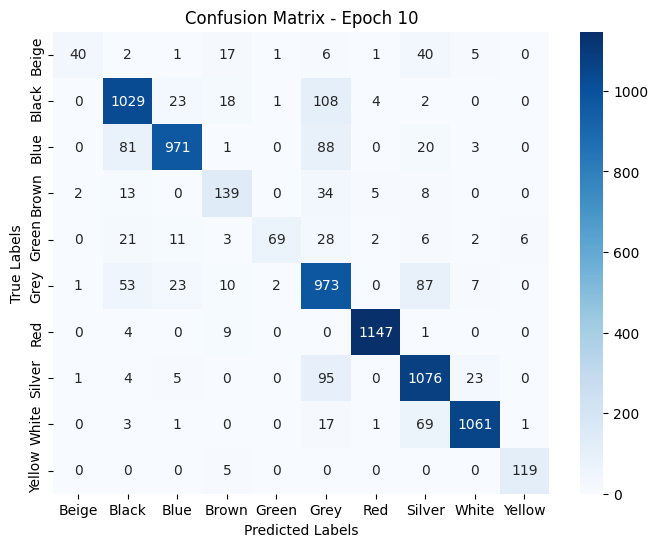

Epoch [10/12], Train Loss: 0.2208, Train Accuracy: 92.29%, Test Loss: 0.4478, F1 Score: 0.8081


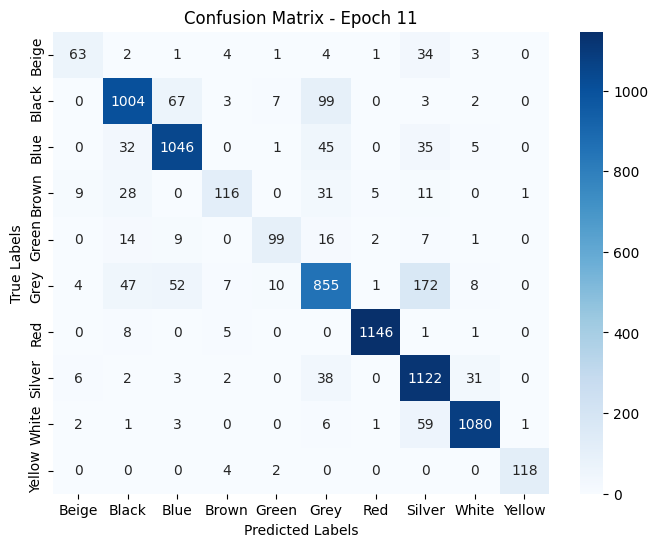

Epoch [11/12], Train Loss: 0.1897, Train Accuracy: 93.47%, Test Loss: 0.4457, F1 Score: 0.8323


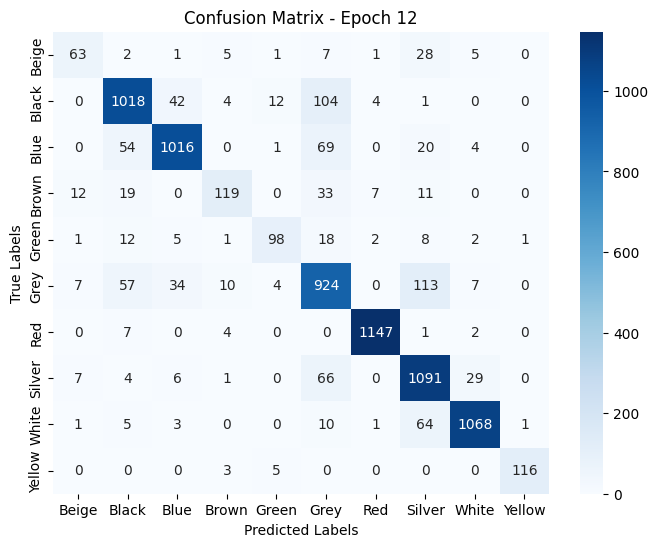

Epoch [12/12], Train Loss: 0.1543, Train Accuracy: 94.60%, Test Loss: 0.4467, F1 Score: 0.8307


In [42]:
learning_rates = [0.0001, 0.001]
batch_sizes = [128, 64]
num_epochs = [12]

results = []
num_classes = len(label_encoder.classes_)

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            print(f"\nОбучение с lr={lr}, batch_size={batch_size}, epochs={epochs}")
            
            model = ResNet(num_classes=num_classes)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            train_losses, test_losses, f1_scores = train_model(
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                num_epochs=epochs,
                lr=lr,
                batch_size=batch_size
            )
            
            results.append({
                'lr': lr,
                'batch_size': batch_size,
                'epochs': epochs,
                'train_losses': train_losses,
                'test_losses': test_losses,
                'f1_scores': f1_scores,
            })


In [43]:
best_result = max(results, key=lambda x: x['f1_scores'])
print("\nЛучшие гиперпараметры")
print(f"Learning rate: {best_result['lr']}")
print(f"Batch size: {best_result['batch_size']}")
print(f"Epochs: {best_result['epochs']}")
print(f"\nЛучший результат F1-macro: {max(best_result['f1_scores']):.4f}")


Лучшие гиперпараметры
Learning rate: 0.0001
Batch size: 64
Epochs: 12

Лучший результат F1-macro: 0.8327


# Предобученная модель

In [44]:
pretrained_model = models.resnet18(pretrained=True)

num_classes = 10  
pretrained_model.fc = torch.nn.Linear(pretrained_model.fc.in_features, num_classes)


C:\Users\kapgo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kapgo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Тренировка предобученной модели

In [45]:
def train_model(model, train_loader, test_loader, lr, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        current_f1 = f1_score(all_labels, all_preds, average='macro')
        if current_f1 > best_f1:
            best_f1 = current_f1
    
    return best_f1

# Подбор гиперпараметров для предобученной модели

In [50]:
hyperparams = [
    {'lr': 0.0001, 'batch_size': 64, 'unfreeze': 20},
    {'lr': 0.0001, 'batch_size': 128, 'unfreeze': 20},
    {'lr': 0.0005, 'batch_size': 64, 'unfreeze': 20},
    {'lr': 0.0005, 'batch_size': 128, 'unfreeze': 20},
]

best_score = 0
best_params = {}

for params in hyperparams:
    print(f"\n1. lr={params['lr']}, batch={params['batch_size']}, unfreeze={params['unfreeze']}")

    model = copy.deepcopy(pretrained_model)
    
    for i, param in enumerate(model.parameters()):
        param.requires_grad = (i >= len(list(model.parameters())) - params['unfreeze'])
    
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])
    
    current_f1 = train_model(model, train_loader, test_loader, params['lr'], epochs=5)
    print(f"F1-macro: {current_f1:.4f}")
    
    if current_f1 > best_score:
        best_score = current_f1
        best_params = params

print(f"\nЛучшие параметры: {best_params}")

final_model = copy.deepcopy(pretrained_model)
total_layers = len(list(final_model.parameters()))
for i, param in enumerate(final_model.parameters()):
    param.requires_grad = (i >= total_layers - best_params['unfreeze'])

final_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
final_test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

train_model(final_model, final_train_loader, final_test_loader, best_params['lr'], epochs=10)



1. lr=0.0001, batch=64, unfreeze=20
F1-macro: 0.8237

1. lr=0.0001, batch=128, unfreeze=20
F1-macro: 0.8222

1. lr=0.0005, batch=64, unfreeze=20
F1-macro: 0.8254

1. lr=0.0005, batch=128, unfreeze=20
F1-macro: 0.8234

Лучшие параметры: {'lr': 0.0005, 'batch_size': 64, 'unfreeze': 20}


0.8335875294124702